## Ethereum Price Classification Model using LSTM

In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping 
from keras.models import load_model
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, classification_report

from keras.backend import clear_session

import warnings
warnings.filterwarnings("ignore")

##### First of all, I define some functions we are going to use.

In [2]:
def partition_dataset(window_length, data, index_target):
    
    """
    The LSTM needs data with the format of [samples, time steps, features], so we create N samples, window_length time steps per sample, and number of features
    """
    x, y = [], []
    data_len = data.shape[0]
    for i in range(window_length, data_len):
        x.append(data[i-window_length:i,:])
        y.append(data[i, index_target])
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [3]:
def binary_classifier_metrics(y_test, y_pred):
    
    """ Return metrics for binary classification models """
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision score: ', precision_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('Recall score: ', recall_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

In [4]:
def plot_history(history):
    
    """ Plot training and validation loss """
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
df = pd.read_csv('data/eth_clean.csv')
df.drop(columns='Unnamed: 0', inplace = True)
df

,date,PriceUSD,AdrActCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1MCnt,CapMrktCurUSD,CapRealUSD,...,FlowOutExUSD,GasUsedTx,GasUsedTxMean,HashRate,RevHashNtv,RevHashRateNtv,RevHashRateUSD,SplyAdrBalUSD1M,TxCnt,TxTfrValMedUSD
0,2015-08-08,1.199990,1208,9958,10267,9550,10115,8111,8.676871e+07,1.500465e+07,...,1.698517e+04,376006093,130512.354391,0.096483,3.360253,290325.822770,348388.084065,1.661840e+07,2881,1.199990
1,2015-08-09,1.199990,1113,10043,10411,9573,10222,8091,8.680133e+07,1.778419e+07,...,1.127113e+05,38863003,29242.289691,0.101360,3.105048,268276.120316,321928.661618,1.682678e+07,1329,15.599147
2,2015-08-10,1.199990,1430,10145,10572,9611,10348,8101,8.683471e+07,1.878138e+07,...,2.135630e+05,74070061,36362.327442,0.111855,2.881582,248968.649994,298759.890307,1.720648e+07,2037,0.718002
3,2015-08-11,0.990000,2697,10188,10706,9614,10429,8081,7.166698e+07,1.869114e+07,...,1.752126e+05,163481740,32940.104775,0.124450,2.607691,225304.507322,223051.462249,1.551874e+07,4963,0.053993
4,2015-08-12,1.288000,1219,10296,10893,9654,10574,8105,9.327472e+07,1.983690e+07,...,1.891297e+05,70102332,34431.400786,0.130915,2.422720,209322.978321,269607.996077,1.851254e+07,2036,12.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,2021-11-15,4569.407770,606036,1166692,18202185,241239,5573039,36595,5.367033e+11,2.735353e+11,...,1.029855e+10,97422476367,75542.615410,817.739849,0.000213,18.400399,84078.925802,1.025092e+08,1289636,456.940777
2292,2021-11-16,4234.131465,609879,1165639,18237665,240967,5580973,36564,4.973249e+11,2.675504e+11,...,1.678261e+09,96356492010,73545.984332,793.794054,0.000219,18.962616,80290.211052,1.022489e+08,1310153,423.413146
2293,2021-11-17,4265.599006,695412,1167736,18217312,241192,5589438,36563,5.010266e+11,2.678047e+11,...,1.282525e+09,98477697827,72772.919850,830.259240,0.000207,17.849640,76139.406528,1.022624e+08,1353219,319.823949
2294,2021-11-18,3985.674373,591159,1170963,18239379,241438,5599347,36605,4.681491e+11,2.625782e+11,...,1.424465e+09,98258045079,76510.060408,851.155962,0.000203,17.527776,69860.008277,1.019504e+08,1284250,398.991334


### 2. Data Processing

In [6]:
def data_processing(df):
    # copy from raw data
    data = df.copy()

    # drop the timestamp columns as it is not used as a predictor
    data.drop(columns='date', inplace=True)

    # ensure all data is float
    data = data.astype(float)

    # create a new feature named "Label": 1 means the price is up, 0 means the price is down or not changed
    data['Label'] = 0

    for i in range(len(data.index)):
        if i == 0:
            data['Label'][i] = 0 
        elif data['PriceUSD'][i] > data['PriceUSD'][i-1]:
            data['Label'][i] = 1 
        else:
            data['Label'][i] = 0 
            
    # normalize the dataset
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(data.values)

    # scale one feature for reversion purpose later
    scaler_pred = MinMaxScaler()
    df_Label = pd.DataFrame(data['Label'])
    np_Label_scaled = scaler_pred.fit_transform(df_Label)
    
    return data, scaler, scaler_pred, np_data_scaled

In [7]:
data, scaler, scaler_pred, np_data_scaled = data_processing(df)

### 3. Data Transformation

- The first 90% of the data is used in training the model, and the last 10% will be used to test the model.
- The RNN-LSTM needs data with the format of [samples, time steps, features], so let's transform data from [num rows x num features] to N samples, sequence_length time steps per sample, and number of features

In [8]:
def data_transformation(sequence_length, np_data_scaled, index_target):
    
    # Split the training data into train and train data sets
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]

    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data, index_target)
    x_test, y_test = partition_dataset(sequence_length, test_data, index_target)

    # Print the shapes:
    print('X_train shape: ', x_train.shape)
    print('y_train shape: ', y_train.shape)
    print('X_test shape: ', x_test.shape)
    print('y_test shape: ', y_test.shape)
    
    return x_train, y_train, x_test, y_test

In [9]:
# Data transformation
sequence_length = 7
x_train, y_train, x_test, y_test = data_transformation(sequence_length, np_data_scaled, data.columns.get_loc("Label"))

X_train shape:  (2060, 7, 25)
y_train shape:  (2060,)
X_test shape:  (229, 7, 25)
y_test shape:  (229,)


### 4. Creating the LSTM Model

In [10]:
def model(x_train):
    
    """
    This model includes:
    - Two LSTM layers with number of neurons is window length * number of features, the input shape is (x_train.shape[1], x_train.shape[2])
    - One fully connect layer with 50 neurons
    - The final dense layer that outputs the predicted value
    - Adam Optimizer
    - Set the loss as the mean_squarred_error
    
    """
    # initial the model
    model = Sequential()

    # Model with n_neurons = window length * number of features
    n_neurons = x_train.shape[1] * x_train.shape[2]

    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

### 5. Training the model

In [11]:
epochs = 50
batch_size = 32

model = model(x_train)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test))

2021-11-26 03:29:07.672175: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 175)            140700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 175)               245700    
_________________________________________________________________
dense (Dense)                (None, 50)                8800      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 395,251
Trainable params: 395,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2021-11-26 03:29:08.098223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


65/65 [==============================] - 5s 37ms/step - loss: 0.6951 - accuracy: 0.5068 - val_loss: 0.7056 - val_accuracy: 0.4498
Epoch 2/50
65/65 [==============================] - 2s 28ms/step - loss: 0.6939 - accuracy: 0.4922 - val_loss: 0.6917 - val_accuracy: 0.5502
Epoch 3/50
65/65 [==============================] - 2s 27ms/step - loss: 0.6926 - accuracy: 0.5141 - val_loss: 0.6913 - val_accuracy: 0.5502
Epoch 4/50
65/65 [==============================] - 2s 27ms/step - loss: 0.6938 - accuracy: 0.5180 - val_loss: 0.6926 - val_accuracy: 0.5459
Epoch 5/50
65/65 [==============================] - 2s 27ms/step - loss: 0.6925 - accuracy: 0.5180 - val_loss: 0.6893 - val_accuracy: 0.5502
Epoch 6/50
65/65 [==============================] - 2s 30ms/step - loss: 0.6925 - accuracy: 0.5092 - val_loss: 0.6889 - val_accuracy: 0.5502
Epoch 7/50
65/65 [==============================] - 2s 31ms/step - loss: 0.6926 - accuracy: 0.5083 - val_loss: 0.7015 - val_accuracy: 0.5502
Epoch 8/50
65/65 [======

### 6. Evaluate Model Performance

In [12]:
def evaluate_model(model, x_test, y_test, scaler_pred):

    # Predict the Ether price
    y_pred_scaled = model.predict(x_test)
        
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
    
    #y_pred_classes=tf.argmax(y_pred,axis=-1)
    y_pred_classes=np.round(y_pred,0)

    # Evaluate the model
    binary_classifier_metrics(y_test, y_pred_classes)
    
    return y_test_unscaled, y_pred_classes, y_pred

#### Plot training and validation loss

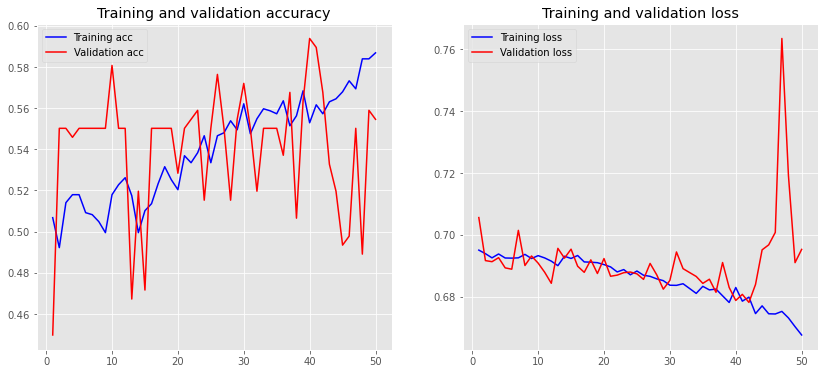

In [13]:
plot_history(history)

#### Model Evaluation

In [14]:
y_test_unscaled, y_pred_classes, y_pred = evaluate_model(model, x_test, y_test, scaler_pred)

Accuracy:  0.5545851528384279
Precision score:  0.603448275862069
F1 score:  0.5785123966942148
Recall score:  0.5555555555555556
Confusion Matrix: 
 [[57 46]
 [56 70]]
